# COGS 118A Final Project - Interpretable Model Performance Across Diverse Tasks


Datasets:
  1. Adult Income (socioeconomic, mixed tabular)
  2. Health and Nutrition (medical/public health, mixed)
  3. Mushroom         
  4. Shuttle                
  5. Digits (vision, numeric)

Models:
  - Logistic Regression
  - Decision Tree
  - K Nearest Neighbors


In [37]:
# Imports
import numpy as np
import pandas as pd

from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

RANDOM_SEEDS = [0, 1, 2]

## Load Data and Preprocess

In [47]:


# ------------------------------------------------------------
# Global settings
# ------------------------------------------------------------

RANDOM_STATE = 42
N_TRIALS = 3            # you can reduce to 1–2 if still heavy
TRAIN_SIZES = [0.2, 0.5, 0.8]

DATASET_NAMES = [
    "adult_income",
    "ckd_risk",
    "shuttle",
    "mushroom",
    "digits"
]



# ------------------------------------------------------------
# Dataset loaders
# ------------------------------------------------------------

def load_adult_income(max_samples=20000):
    """
    Adult / Census Income dataset (UCI id=2).
    Binary task: income >50K (1) vs <=50K (0).

    If too large, stratified-subset to at most `max_samples`.
    """
    from sklearn.model_selection import StratifiedShuffleSplit

    ds = fetch_ucirepo(id=2)
    X_full = ds.data.features.copy()
    targets = ds.data.targets

    if isinstance(targets, pd.DataFrame):
        y_raw = targets.iloc[:, 0].astype(str)
    else:
        y_raw = targets.astype(str)

    y_full = y_raw.str.contains(">50K").astype(int)

    print("\n[Adult] original size:", X_full.shape[0])

    if X_full.shape[0] > max_samples:
        print(f"[Adult] Subsampling to {max_samples} rows (stratified).")
        splitter = StratifiedShuffleSplit(
            n_splits=1,
            train_size=max_samples,
            random_state=RANDOM_STATE
        )
        for idx, _ in splitter.split(X_full, y_full):
            X = X_full.iloc[idx].reset_index(drop=True)
            y = y_full.iloc[idx].reset_index(drop=True)
            break
    else:
        X = X_full.reset_index(drop=True)
        y = y_full.reset_index(drop=True)

    print("[Adult] final size used:", X.shape[0])
    print("[Adult] class counts:\n", y.value_counts())
    info = {"name": "Adult Income", "is_text": False}
    return X, y, info


def load_ckd_risk():
    """
    Load UCI ID 857: Risk Factor Prediction of Chronic Kidney Disease.
    Binary task: CKD vs non-CKD.
    """
    ds = fetch_ucirepo(id=857)

    X = ds.data.features.copy()
    targets = ds.data.targets.copy()

    # Get raw label strings
    if isinstance(targets, pd.DataFrame):
        target_col = targets.columns[0]
        labels = targets[target_col].astype(str).str.lower().str.strip()
    else:
        labels = targets.astype(str).str.lower().str.strip()

    # Inspect once if you want
    print("\n[CKD Risk] Raw labels:")
    print(labels.value_counts())

    # Map to binary:
    #   1 = "ckd"
    #   0 = everything else (e.g., "notckd", "no ckd", etc.)
    y = (labels == "ckd").astype(int)

    print("\n[CKD Risk] Binary class counts (1=CKD, 0=non-CKD):")
    print(y.value_counts())

    info = {
        "name": "Risk Factor Prediction of Chronic Kidney Disease (Binary)",
        "is_text": False
    }
    return X, y, info



def load_shuttle(max_samples=50000):
    """
    Statlog Shuttle dataset (UCI id=148).
    Original labels: 1–7.
    Paper converts to binary: class 1 vs others.

        0 = class 1 (majority)
        1 = classes 2–7 (rare classes combined)

    Dataset is very large; we optionally subsample to max_samples
    for computational reasons.
    """
    from sklearn.model_selection import StratifiedShuffleSplit
    ds = fetch_ucirepo(id=148)

    X_full = ds.data.features.copy()
    targets = ds.data.targets

    if isinstance(targets, pd.DataFrame):
        y_raw = targets.iloc[:, 0].astype(int)
    else:
        y_raw = targets.astype(int)

    # Binary mapping: class 1 vs others
    y_full = (y_raw != 1).astype(int)  # 1 = minority (non-1), 0 = majority (1)

    print("\n[Shuttle] original size:", X_full.shape[0])
    print("[Shuttle] class counts (1=rare, 0=majority):\n", y_full.value_counts())

    # Optional subsampling (Shuttle is huge)
    if X_full.shape[0] > max_samples:
        print(f"[Shuttle] Subsampling to {max_samples} rows (stratified).")
        splitter = StratifiedShuffleSplit(
            n_splits=1,
            train_size=max_samples,
            random_state=RANDOM_STATE
        )
        for idx, _ in splitter.split(X_full, y_full):
            X = X_full.iloc[idx].reset_index(drop=True)
            y = y_full.iloc[idx].reset_index(drop=True)
            break
    else:
        X = X_full.reset_index(drop=True)
        y = y_full.reset_index(drop=True)

    print("[Shuttle] final size used:", X.shape[0])
    print("[Shuttle] class counts (after subsample):\n", y.value_counts())

    info = {
        "name": "Statlog Shuttle (1 vs Others)",
        "is_text": False
    }
    return X, y, info


def load_mushroom():
    """
    Mushroom dataset (UCI id=73).
    All features are categorical: cap-shape, cap-color, odor, etc.
    Binary task: poisonous vs edible.

    We map:
        1 = poisonous
        0 = edible
    so that 1 corresponds to the 'risky' class.
    """
    ds = fetch_ucirepo(id=73)
    X = ds.data.features.copy()
    targets = ds.data.targets

    # usually the target column has values 'e' (edible) and 'p' (poisonous)
    if isinstance(targets, pd.DataFrame):
        y_raw = targets.iloc[:, 0].astype(str)
    else:
        y_raw = targets.astype(str)

    y = (y_raw == "p").astype(int)   # 1 = poisonous, 0 = edible

    print("\n[Mushroom] shape:", X.shape)
    print("[Mushroom] class counts (1=poisonous, 0=edible):\n", y.value_counts())

    info = {
        "name": "Mushroom (Poisonous vs Edible)",
        "is_text": False
    }
    return X, y, info


def load_digits():
    """
    Optical Recognition of Handwritten Digits (UCI id=80).
    Binary task: digits 5–9 (1) vs 0–4 (0).
    """
    ds = fetch_ucirepo(id=80)
    X = ds.data.features.copy()
    targets = ds.data.targets

    if isinstance(targets, pd.DataFrame):
        y_raw = targets.iloc[:, 0].astype(int)
    else:
        y_raw = targets.astype(int)

    y = (y_raw >= 5).astype(int)

    print("\n[Digits] class counts:\n", y.value_counts())
    info = {"name": "Digits (5–9 vs 0–4)", "is_text": False}
    return X, y, info


def load_dataset_by_name(name):
    if name == "adult_income":
        return load_adult_income()
    elif name == "ckd_risk":
        return load_ckd_risk()
    elif name == "shuttle":
        return load_shuttle()
    elif name == "mushroom":
        return load_mushroom()
    elif name == "digits":
        return load_digits()
    else:
        raise ValueError(f"Unknown dataset name: {name}")




# ------------------------------------------------------------
# Models & hyperparameters
# ------------------------------------------------------------

def get_models_and_grids():
    models = {
        "log_reg": LogisticRegression(max_iter=1000),
        "decision_tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
        "knn": KNeighborsClassifier()
    }

    param_grids = {
        "log_reg": {
            "clf__C": [0.01, 0.1, 1.0, 10.0],
            "clf__penalty": ["l2"],
            "clf__solver": ["liblinear"]
        },
        "decision_tree": {
            "clf__max_depth": [None, 5, 10, 20],
            "clf__min_samples_leaf": [1, 5, 10]
        },
        "knn": {
            "clf__n_neighbors": [3, 5, 11],
            "clf__weights": ["uniform", "distance"]
        }
    }

    return models, param_grids


# ------------------------------------------------------------
# Preprocessing
# ------------------------------------------------------------

def build_tabular_preprocessor(X_train):
    numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

    numeric_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_pipeline, numeric_cols),
            ("cat", categorical_pipeline, categorical_cols)
        ],
        remainder="drop"
    )

    return preprocessor


def build_text_preprocessor():
    text_pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(stop_words="english", max_features=5000)),
        ("svd", TruncatedSVD(n_components=100, random_state=RANDOM_STATE))
    ])
    return text_pipeline


def build_pipeline(model_name, base_model, is_text, X_train=None):
    if is_text:
        text_pre = build_text_preprocessor()
        pipe = Pipeline([
            ("preprocess", text_pre),
            ("clf", base_model)
        ])
    else:
        if X_train is None:
            raise ValueError("X_train must be provided for tabular data.")
        tab_pre = build_tabular_preprocessor(X_train)
        pipe = Pipeline([
            ("preprocess", tab_pre),
            ("clf", base_model)
        ])
    return pipe


## Experiment

In [48]:
# Experiment loop

def run_experiments():

    models, param_grids = get_models_and_grids()
    all_results = []

    for dataset_key in DATASET_NAMES:
        X_raw, y, info = load_dataset_by_name(dataset_key)
        print(f"\n=== Dataset: {info['name']} ({dataset_key}) ===")
        is_text = info["is_text"]

        if is_text:
            X_array = X_raw.values
        else:
            X_array = X_raw

        for train_size in TRAIN_SIZES:
            print(f"\n  Train size = {train_size:.2f}")

            splitter = StratifiedShuffleSplit(
                n_splits=N_TRIALS,
                train_size=train_size,
                random_state=RANDOM_STATE
            )

            for trial_idx, (train_idx, test_idx) in enumerate(
                splitter.split(X_array, y),
                start=1
            ):
                print(f"    Trial {trial_idx}/{N_TRIALS}")

                if is_text:
                    X_train = X_array[train_idx]
                    X_test = X_array[test_idx]
                else:
                    X_train = X_array.iloc[train_idx].copy()
                    X_test = X_array.iloc[test_idx].copy()

                y_train = y.iloc[train_idx]
                y_test = y.iloc[test_idx]

                for model_name, base_model in models.items():
                    print(f"      Model: {model_name}")

                    pipe = build_pipeline(
                        model_name=model_name,
                        base_model=base_model,
                        is_text=is_text,
                        X_train=None if is_text else X_train
                    )
                    param_grid = param_grids[model_name]

                    grid = GridSearchCV(
                        estimator=pipe,
                        param_grid=param_grid,
                        cv=3,
                        scoring="accuracy",
                        n_jobs=1 
                    )
                    grid.fit(X_train, y_train)

                    y_train_pred = grid.predict(X_train)
                    y_test_pred = grid.predict(X_test)

                    train_acc = accuracy_score(y_train, y_train_pred)
                    test_acc = accuracy_score(y_test, y_test_pred)
                    val_acc_cv = grid.best_score_
                    best_params = grid.best_params_

                    result_row = {
                        "dataset_key": dataset_key,
                        "dataset_name": info["name"],
                        "is_text": is_text,
                        "train_size": train_size,
                        "trial": trial_idx,
                        "model": model_name,
                        "train_acc": train_acc,
                        "val_acc_cv": val_acc_cv,
                        "test_acc": test_acc,
                    }
                    for k, v in best_params.items():
                        result_row[f"best_{k}"] = v

                    all_results.append(result_row)

    results_df = pd.DataFrame(all_results)
    return results_df


# ------------------------------------------------------------
# Convert to Results Dataframe
# ------------------------------------------------------------

if __name__ == "__main__":
    results_df = run_experiments()

    results_df.to_csv("all_results_raw.csv", index=False)

    summary = (
        results_df
        .groupby(["dataset_key", "dataset_name", "model", "train_size"])
        [["train_acc", "val_acc_cv", "test_acc"]]
        .mean()
        .reset_index()
    )

    summary.to_csv("summary_results.csv", index=False)

    print("\n=== Summary (first few rows) ===")
    print(summary.head())



[Adult] original size: 48842
[Adult] Subsampling to 20000 rows (stratified).
[Adult] final size used: 20000
[Adult] class counts:
 income
0    15214
1     4786
Name: count, dtype: int64

=== Dataset: Adult Income (adult_income) ===

  Train size = 0.20
    Trial 1/3
      Model: log_reg
      Model: decision_tree
      Model: knn
    Trial 2/3
      Model: log_reg
      Model: decision_tree
      Model: knn
    Trial 3/3
      Model: log_reg
      Model: decision_tree
      Model: knn

  Train size = 0.50
    Trial 1/3
      Model: log_reg
      Model: decision_tree
      Model: knn
    Trial 2/3
      Model: log_reg
      Model: decision_tree
      Model: knn
    Trial 3/3
      Model: log_reg
      Model: decision_tree
      Model: knn

  Train size = 0.80
    Trial 1/3
      Model: log_reg
      Model: decision_tree
      Model: knn
    Trial 2/3
      Model: log_reg
      Model: decision_tree
      Model: knn
    Trial 3/3
      Model: log_reg
      Model: decision_tree
      Mode

In [49]:
summary.sort_values(by='test_acc', ascending=False, inplace=False)

,dataset_key,dataset_name,model,train_size,train_acc,val_acc_cv,test_acc
28,mushroom,Mushroom (Poisonous vs Edible),decision_tree,0.5,1.000000,0.999590,1.000000
9,ckd_risk,Risk Factor Prediction of Chronic Kidney Disea...,decision_tree,0.2,1.000000,1.000000,1.000000
34,mushroom,Mushroom (Poisonous vs Edible),log_reg,0.5,1.000000,0.999508,1.000000
17,ckd_risk,Risk Factor Prediction of Chronic Kidney Disea...,log_reg,0.8,1.000000,1.000000,1.000000
14,ckd_risk,Risk Factor Prediction of Chronic Kidney Disea...,knn,0.8,1.000000,0.997904,1.000000
11,ckd_risk,Risk Factor Prediction of Chronic Kidney Disea...,decision_tree,0.8,1.000000,1.000000,1.000000
31,mushroom,Mushroom (Poisonous vs Edible),knn,0.5,1.000000,0.999754,1.000000
10,ckd_risk,Risk Factor Prediction of Chronic Kidney Disea...,decision_tree,0.5,1.000000,1.000000,1.000000
29,mushroom,Mushroom (Poisonous vs Edible),decision_tree,0.8,1.000000,0.999744,1.000000
32,mushroom,Mushroom (Poisonous vs Edible),knn,0.8,1.000000,0.999744,1.000000


## Figures

/var/folders/75/2nxjlm2s77d1nl75246pfh6h0000gn/T/ipykernel_986/385552778.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(leaderboard["model"], rotation=45, ha="right")


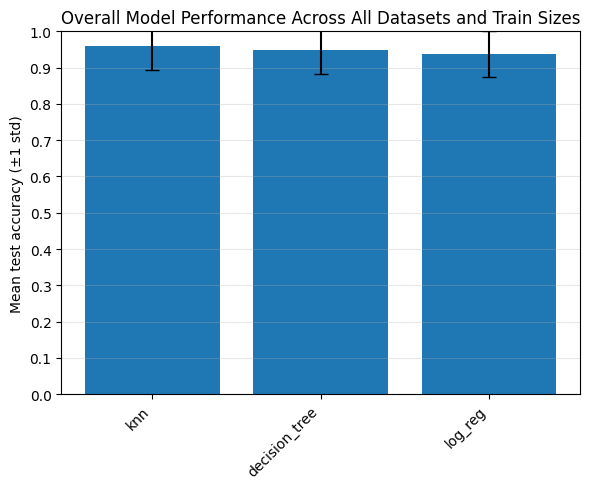

In [57]:
# === Figure 5: Overall leaderboard of models ===

leaderboard = (
    results_df
    .groupby("model")["test_acc"]
    .agg(["mean", "std"])
    .reset_index()
)

leaderboard = leaderboard.sort_values("mean", ascending=False)

fig, ax = plt.subplots(figsize=(6, 5))

ax.bar(leaderboard["model"], leaderboard["mean"],
       yerr=leaderboard["std"], capsize=5)

ax.set_ylabel("Mean test accuracy (±1 std)")
ax.set_ylim(0.0, 1.0)
plt.yticks(np.arange(0, 1.1, 0.1))
ax.set_title("Overall Model Performance Across All Datasets and Train Sizes")
ax.grid(axis="y", alpha=0.3)
ax.set_xticklabels(leaderboard["model"], rotation=45, ha="right")

fig.tight_layout()
plt.show()


/var/folders/75/2nxjlm2s77d1nl75246pfh6h0000gn/T/ipykernel_986/1540369234.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub["model"], rotation=45, ha="right")
/var/folders/75/2nxjlm2s77d1nl75246pfh6h0000gn/T/ipykernel_986/1540369234.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub["model"], rotation=45, ha="right")
/var/folders/75/2nxjlm2s77d1nl75246pfh6h0000gn/T/ipykernel_986/1540369234.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub["model"], rotation=45, ha="right")
/var/folders/75/2nxjlm2s77d1nl75246pfh6h0000gn/T/ipykernel_986/1540369234.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using 

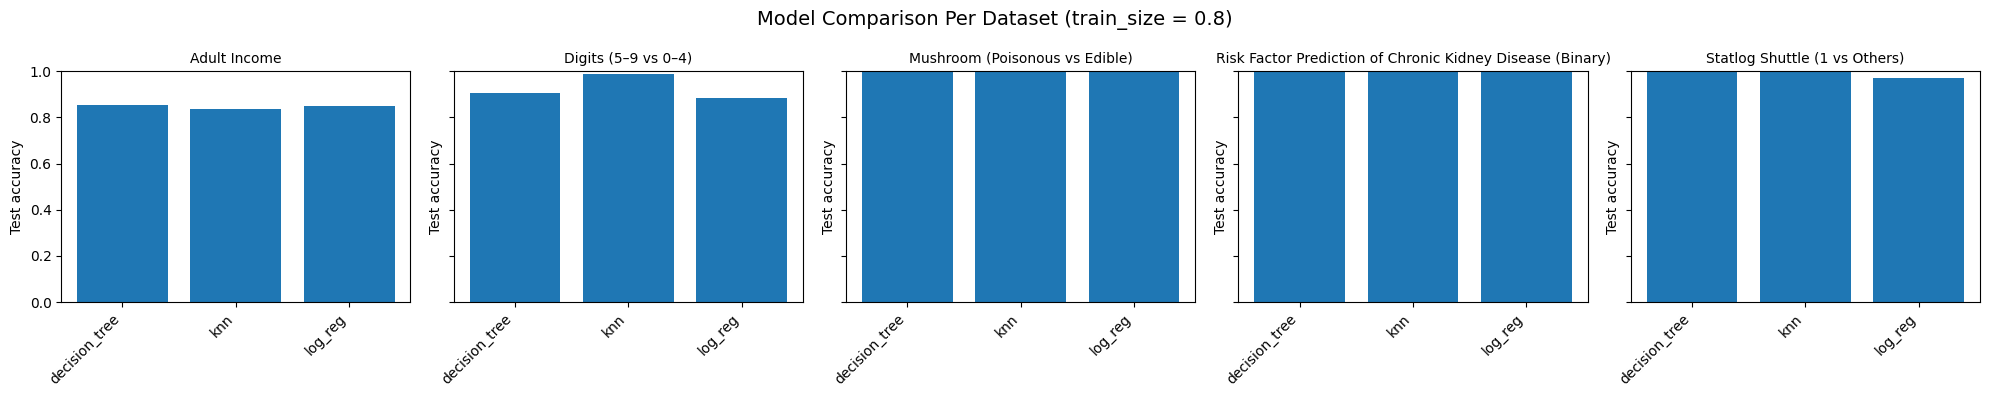

In [51]:
# === Figure 1: Bar chart of models per dataset (train_size = 0.8) ===

train_size_for_plot = 0.8  # change to 0.5 or 0.2 if you want

df80 = results_df[results_df["train_size"] == train_size_for_plot]

# Aggregate: mean test accuracy over trials
agg = (
    df80
    .groupby(["dataset_name", "model"])["test_acc"]
    .mean()
    .reset_index()
)

datasets = agg["dataset_name"].unique()
models = sorted(agg["model"].unique())

n_datasets = len(datasets)
fig, axes = plt.subplots(
    1, n_datasets,
    figsize=(4 * n_datasets, 4),
    sharey=True
)

if n_datasets == 1:
    axes = [axes]

for ax, dname in zip(axes, datasets):
    sub = agg[agg["dataset_name"] == dname]
    # ensure correct order
    sub = sub.set_index("model").loc[models].reset_index()

    ax.bar(sub["model"], sub["test_acc"])
    ax.set_title(dname, fontsize=10)
    ax.set_ylim(0.0, 1.0)
    ax.set_xticklabels(sub["model"], rotation=45, ha="right")
    ax.set_ylabel("Test accuracy")

fig.suptitle(f"Model Comparison Per Dataset (train_size = {train_size_for_plot})",
             fontsize=14)
fig.tight_layout()
plt.show()
